In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### analysis functions - code only

In [2]:
def load_model_data(model_name):
    """Load data for a specific model"""
    try:
        distances = pd.read_csv(f"logit_lens_results/{model_name}/cosine_similarity.csv")
        predictions = pd.read_csv(f"logit_lens_results/{model_name}/predictions.csv")
        last_layer_probs = pd.read_csv(f"logit_lens_results/{model_name}/last_layer_top_class_probs.csv")
        true_class_probs = pd.read_csv(f"logit_lens_results/{model_name}/true_class_probs.csv")
        #random_class_probs = pd.read_csv(f"logit_lens_results/{model_name}/random_class_probs.csv")
        random_class_probs = None
        first_top_class_probs = pd.read_csv(f"logit_lens_results/{model_name}/first_top_class_probs.csv")
        divergence = pd.read_csv(f"logit_lens_results/{model_name}/kl_divergence.csv")

        return distances, predictions, last_layer_probs, true_class_probs, random_class_probs, first_top_class_probs, divergence
    except Exception as e:
        print(f"Error loading {model_name}: {e}")
        return None, None

In [3]:
import numpy as np
import pandas as pd

def analyze_single_model_dynamics(distances_df, predictions_df, model_name, class_col=None, export_csv=False):
    """Analyze dynamics for a single model and optionally per class"""
    def compute_layer_stats(sub_df):
        layer_cols = [col for col in sub_df.columns if col.startswith('layer_')]
        layer_nums = sorted([int(col.split('_')[1]) for col in layer_cols])
        stats = {}
        for layer_num in layer_nums:
            col_name = f'layer_{layer_num}'
            sims = sub_df[col_name].dropna()
            stats[layer_num] = {
                'mean_sim': sims.mean(),
                'std_sim': sims.std(),
                'median_sim': sims.median(),
                'q25': sims.quantile(0.25),
                'q75': sims.quantile(0.75),
                'stability': 1 / (sims.std() + 1e-6),
                'count': len(sims)
            }
        return stats, layer_nums

    def analyze_critical_layers(layer_stats, layer_nums):
        similarities_sequence = [layer_stats[ln]['mean_sim'] for ln in layer_nums]
        convergence_rates = [
            abs(similarities_sequence[i] - similarities_sequence[i-1])
            for i in range(1, len(similarities_sequence))
        ]

        # Critical layers
        critical_layers = []
        if convergence_rates:
            mean_conv = np.mean(convergence_rates)
            std_conv = np.std(convergence_rates)
            threshold = mean_conv + 1.5 * std_conv
            for i, rate in enumerate(convergence_rates):
                if rate > threshold:
                    critical_layers.append({
                        'layer': layer_nums[i+1],
                        'change_rate': rate
                    })

        least_critical_info = sorted(
            zip(layer_nums[1:], convergence_rates), key=lambda x: x[1]
        )[:3]
        least_critical_layers = [{'layer': layer, 'change_rate': rate} for layer, rate in least_critical_info]

        return convergence_rates, critical_layers, least_critical_layers, similarities_sequence

    def compute_metrics(layer_stats, layer_nums, similarities_sequence, convergence_rates, critical_layers, least_critical_layers):
        if len(layer_nums) > 1:
            auc = np.trapz(similarities_sequence, layer_nums)
            max_auc = layer_nums[-1] * 1.0
            efficiency = auc / max_auc
        else:
            efficiency = similarities_sequence[0] if similarities_sequence else 0

        convergence_layer = None
        for i, sim in enumerate(similarities_sequence):
            if sim >= 0.8:
                convergence_layer = layer_nums[i]
                break

        stability_scores = [layer_stats[ln]['stability'] for ln in layer_nums]
        overall_stability = np.mean(stability_scores) if stability_scores else 0

        return {
            'efficiency': efficiency,
            'convergence_layer': convergence_layer,
            'final_similarity': similarities_sequence[-1] if similarities_sequence else 0,
            'similarities_sequence': similarities_sequence,
            'layer_nums': layer_nums,
            'overall_stability': overall_stability,
            'num_critical_layers': len(critical_layers),
            'max_similarity': max(similarities_sequence),
            'min_similarity': min(similarities_sequence),
            'similarity_range': max(similarities_sequence) - min(similarities_sequence),
            'least_critical_layers': least_critical_layers
        }

    all_deltas = []

    def analyze_group(df, label=None):
        stats, layers = compute_layer_stats(df)
        deltas, crit, least, sims = analyze_critical_layers(stats, layers)
        metrics = compute_metrics(stats, layers, sims, deltas, crit, least)

        top3_critical = sorted(
            [{'layer': layers[i+1], 'change_rate': rate, 'class': label} for i, rate in enumerate(deltas)],
            key=lambda x: -x['change_rate']
        )[:3]

        top3_least = sorted(
            [{'layer': layers[i+1], 'change_rate': rate, 'class': label} for i, rate in enumerate(deltas)],
            key=lambda x: x['change_rate']
        )[:3]

        all_deltas.extend([
            {'layer': layers[i+1], 'change_rate': rate, 'class': label}
            for i, rate in enumerate(deltas)
        ])

        return stats, top3_critical, metrics, top3_least
 

    # Overall
    layer_stats, critical_layers, metrics, least_critical_layers = analyze_group(distances_df)

    # Class-wise if enabled
    classwise_results = []
    if class_col:
        for cls in predictions_df[class_col].unique():
            cls_indices = predictions_df[predictions_df[class_col] == cls].index
            cls_df = distances_df.loc[cls_indices]
            _, cls_critical, _, cls_least = analyze_group(cls_df, label=cls)

            for rank, item in enumerate(cls_critical, start=1):
                item['type'] = 'critical'
                item['rank'] = rank
                classwise_results.append(item)

            for rank, item in enumerate(cls_least, start=1):
                item['type'] = 'least_critical'
                item['rank'] = rank
                classwise_results.append(item)

    if export_csv and classwise_results:
        df_out = pd.DataFrame(classwise_results)
        cols = ['class', 'layer', 'change_rate', 'type', 'rank']
        df_out = df_out[cols]  # enforce column order
        #overwrite existing file if it exists
        df_out.to_csv(f"logit_lens_results/{model_name}/critical_layers.csv", index=False)
        print(f"Critical layers saved to logit_lens_results/{model_name}/critical_layers.csv")


    # Final global 3 most and 3 least critical (mean change rate)
    all_layer_deltas = pd.DataFrame(all_deltas)
    mean_deltas = all_layer_deltas.groupby('layer')['change_rate'].mean().reset_index()

    most_critical_overall = mean_deltas.nlargest(3, 'change_rate').to_dict(orient='records')
    least_critical_overall = mean_deltas.nsmallest(3, 'change_rate').to_dict(orient='records')

    # === Summary ===
    print(f"\n=== SUMMARY FOR MODEL: {model_name} ===")
    print(f"• Layers analyzed: {len(metrics['layer_nums'])}")
    print(f"• Final similarity: {metrics['final_similarity']:.4f}")
    print(f"• Similarity range: {metrics['similarity_range']:.4f}")
    print(f"• Overall stability: {metrics['overall_stability']:.4f}")
    print(f"• Convergence layer: {metrics['convergence_layer']}")
    print(f"• Number of critical layers: {metrics['num_critical_layers']}")
    print(f"• Critical layers: {', '.join(str(c['layer']) for c in critical_layers)}")
    print(f"• Least critical: {', '.join(str(l['layer']) for l in least_critical_layers)}")
    print(f"• === Overall Most Critical Layers ===")
    for c in most_critical_overall:
        print(f"   - Layer {c['layer']}: Δ={c['change_rate']:.4f}")
    print(f"• === Overall Least Critical Layers ===")
    for c in least_critical_overall:
        print(f"   - Layer {c['layer']}: Δ={c['change_rate']:.4f}")

    return layer_stats, critical_layers, metrics

In [4]:
def analyze_prediction_consistency(predictions_df):
    """
    Analyze how often the final label appears in earlier layers,
    track prediction stability, and evaluate probability trends.

    Returns:
        - Summary statistics printed
        - Detailed results per image
    """
    
    label_cols = [col for col in predictions_df.columns if '_label' in col]
    prob_cols = [col for col in predictions_df.columns if '_prob' in col]
    num_layers = len(label_cols)

    results = []

    for idx, row in predictions_df.iterrows():
        image_id = row['Image']
        labels = row[label_cols].values
        probs = row[prob_cols].values.astype(float)
        final_label = labels[-1]

        # First occurrence of final label
        try:
            first_occurrence = list(labels).index(final_label)
        except ValueError:
            first_occurrence = None

        # How many layers match the final label
        match_count = sum(label == final_label for label in labels[:-1])  # exclude final
        match_fraction = match_count / (num_layers - 1)

        # Plateaus: ranges of consecutive identical predictions
        plateaus = []
        current_label = labels[0]
        start_idx = 0
        for i in range(1, num_layers):
            if labels[i] != current_label:
                if i - start_idx > 1:
                    plateaus.append((start_idx, i - 1, current_label))
                start_idx = i
                current_label = labels[i]
        if num_layers - start_idx > 1:
            plateaus.append((start_idx, num_layers - 1, current_label))

        # Probability consistency (std deviation across layers)
        prob_std = np.std(probs)
        prob_max = np.max(probs)
        prob_min = np.min(probs)

        results.append({
            'Image': image_id,
            'final_label': final_label,
            'first_occurrence_of_final': first_occurrence,
            'fraction_layers_matching_final': match_fraction,
            'num_plateaus': len(plateaus),
            'plateaus': plateaus,
            'prob_std': prob_std,
            'prob_max': prob_max,
            'prob_min': prob_min,
            'prob_range': prob_max - prob_min
        })

    results_df = pd.DataFrame(results)

    # === Summary ===
    print("\n=== PREDICTION CONSISTENCY SUMMARY ===")
    total_images = len(results_df)
    early_hits = results_df['first_occurrence_of_final'].dropna().apply(lambda x: x < num_layers - 1).sum()
    print(f"• Total images: {total_images}")
    print(f"• Images where final label appeared early: {early_hits} ({(early_hits / total_images):.2%})")

    avg_first_occurrence = results_df['first_occurrence_of_final'].dropna().mean()
    print(f"• Avg. first occurrence of final label: {avg_first_occurrence:.2f} (out of {num_layers})")

    avg_match_fraction = results_df['fraction_layers_matching_final'].mean()
    print(f"• Avg. fraction of layers matching final label: {avg_match_fraction:.2f}")

    avg_plateaus = results_df['num_plateaus'].mean()
    print(f"• Avg. number of prediction plateaus per image: {avg_plateaus:.2f}")

    avg_prob_std = results_df['prob_std'].mean()
    print(f"• Avg. probability std across layers: {avg_prob_std:.4f}")

    return results_df


In [5]:

def compare_models_comprehensive():
    """Comprehensive comparison across all three models"""
    
    models = ['CLIP', 'CLIP_L', 'DINO_lp']
    model_results = {}
    
    print("=== LOADING MODEL DATA ===")
    for model in models:
        distances, predictions, last_layer_probs, true_class_probs, random_class_probs, first_top_class_probs, divergence = load_model_data(model)
        if distances is not None and predictions is not None:
            layer_stats, critical_layers, metrics = analyze_single_model_dynamics(
                distances, predictions, model, class_col = "True_Label", export_csv=True
            )
            model_results[model] = {
                'layer_stats': layer_stats,
                'critical_layers': critical_layers,
                'metrics': metrics,
                'distances': distances,
                'predictions': predictions
            }
        analyzed_predictions = analyze_prediction_consistency(predictions)
    
    if not model_results:
        print("No model data loaded successfully!")
        return None
    
    print(f"\n✓ Successfully loaded {len(model_results)} models: {list(model_results.keys())}")
    
    # Create comprehensive comparison table
    print("\n=== MODEL COMPARISON SUMMARY ===")
    comparison_data = []
    
    for model_name, results in model_results.items():
        metrics = results['metrics']
        row = {
            'Model': model_name,
            'Num_Layers': len(metrics['layer_nums']),
            'Efficiency': metrics['efficiency'],
            'Final_Similarity': metrics['final_similarity'],
            'Convergence_Layer': metrics['convergence_layer'] if metrics['convergence_layer'] else 'None',
            'Critical_Layers': metrics['num_critical_layers'],
            'Overall_Stability': metrics['overall_stability'],
            'Similarity_Range': metrics['similarity_range']
        }
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.round(4).to_string(index=False))
    
    # create_multi_model_visualizations(model_results)
    # generate_comparative_insights(model_results, comparison_df)

    return model_results, comparison_df

In [6]:
def create_multi_model_visualizations(model_results):
    """Create comprehensive multi-model visualization, excluding the last layer and non-representational metrics."""

    # Set up the figure with subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1.2], hspace=0.4)

    models = list(model_results.keys())
    colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange

    # 1. Similarity progression comparison
    ax1 = fig.add_subplot(gs[0, 0])

    for i, (model_name, results) in enumerate(model_results.items()):
        metrics = results['metrics']
        layer_nums = metrics['layer_nums']
        similarities = metrics['similarities_sequence'][:len(layer_nums)]

        ax1.plot(layer_nums, similarities, 'o-', linewidth=3, markersize=6,
                 color=colors[i], alpha=0.8, label=f'{model_name}')

        layer_stats = results['layer_stats']
        if layer_stats:
            stds = [layer_stats[ln]['std_sim'] for ln in layer_nums]
            ax1.fill_between(layer_nums,
                             np.array(similarities) - np.array(stds),
                             np.array(similarities) + np.array(stds),
                             alpha=0.2, color=colors[i])

    ax1.set_xlabel('Layer Number', fontsize=12)
    ax1.set_ylabel('Cosine Similarity', fontsize=12)
    ax1.set_title('Representational Convergence: Model Comparison', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)

    ax3 = fig.add_subplot(gs[2, 0])

    max_layers = max(len(results['metrics']['layer_nums']) - 1 for results in model_results.values())
    stability_matrix = np.full((len(models), max_layers), np.nan)

    layer_labels = []
    for i, (model_name, results) in enumerate(model_results.items()):
        layer_stats = results['layer_stats']
        layer_nums = results['metrics']['layer_nums'][:-1]

        for j, layer_num in enumerate(layer_nums):
            stability_matrix[i, j] = layer_stats[layer_num]['stability']

        if i == 0:
            layer_labels = [f'L{ln}' for ln in layer_nums]

    while len(layer_labels) < max_layers:
        layer_labels.append(f'L{len(layer_labels)}')

    sns.heatmap(stability_matrix,
                yticklabels=models,
                xticklabels=layer_labels[:max_layers],
                cmap='viridis',
                ax=ax3,
                cbar_kws={'label': 'Stability Score'},
                fmt='.1f')
    ax3.set_title('Layer-wise Stability Comparison', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Layer')
    ax3.set_ylabel('Model')

    plt.suptitle('Comprehensive Multi-Model Logit Lens Analysis', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()


In [7]:
def plot_cosine_similarity(distances, predictions):
    layer_names = sorted(
        [k for k in distances.keys() if k.startswith("layer_")],
        key=lambda x: int(x.split('_')[1])
    )

    try:
        similarity_values = [float(distances[layer]) for layer in layer_names]
        prob_values = [float(predictions.get(f"{layer}_prob", np.nan)) for layer in layer_names]
        predicted_labels = [predictions.get(f"{layer}_label", "") for layer in layer_names]
    except Exception as e:
        print("Error preparing data:", e)
        return

    if not all(isinstance(v, (int, float)) for v in similarity_values + prob_values):
        print("Some values are not numeric.")
        return

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 1]})

    sns.heatmap(np.array(similarity_values).reshape(1, -1), annot=True, cmap="viridis",
                xticklabels=layer_names, yticklabels=["Cosine Similarity"], cbar=True,
                ax=axes[0], cbar_kws={'label': 'Cosine Similarity'})

    sns.heatmap(np.array(prob_values).reshape(1, -1), annot=True, cmap="magma",
                xticklabels=layer_names, yticklabels=["Prediction Prob."], cbar=True,
                ax=axes[1], cbar_kws={'label': 'Prediction Probability'})

    for i, label in enumerate(predicted_labels):
        if label is not None and label != "":
            axes[1].text(i + 0.5, -0.05, str(label), ha='center', va='bottom',
                         color='black', fontsize=9, rotation=90,
                         transform=axes[1].transData)


    plt.suptitle("Cosine Similarity & Prediction Probability per Layer", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93]) 
    plt.show()

### cosine similarity, kl divergence, true probability plots

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_metrics_for_classes(classes, model_names, data_loader_fn):
    """
    Plot average cosine similarity, KL divergence, and true class probability
    per selected class, with different plots per model and lines per class.

    Arguments:
        classes: list of class WNIDs or labels to visualize
        model_names: list of model name strings (e.g., ['CLIP', 'DINO'])
        data_loader_fn: function that takes model_name and returns:
            distances, predictions, last_layer_probs, true_class_probs,
            random_class_probs, first_top_class_probs, divergence
    """
    colors = [
        '#2E86AB', '#A23B72', "#ED8E00", '#C73E1D', '#28AFB0',
        '#6A4C93', "#FFC021", "#F274B7", "#57CA53", '#3D348B'
    ]

    fig, axs = plt.subplots(nrows=3, ncols=len(model_names), figsize=(6 * len(model_names), 15))
    metrics = ['Cosine Similarity', 'KL Divergence', 'True Class Probability']

    # Collect legend handles/labels from first subplot in each row
    legend_handles_per_row = [[] for _ in range(3)]

    for model_idx, model_name in enumerate(model_names):
        distances, predictions, _, true_class_probs, _, _, divergence = data_loader_fn(model_name)

        cosine_df = pd.DataFrame(distances)
        kl_df = pd.DataFrame(divergence)
        true_prob_df = pd.DataFrame(true_class_probs)

        metric_dfs = [cosine_df, kl_df, true_prob_df]

        for row_idx, (df, ylabel) in enumerate(zip(metric_dfs, metrics)):
            ax = axs[row_idx, model_idx]

            for color_idx, cls in enumerate(classes):
                filtered = df[df['True_Label'] == cls]
                layer_data = filtered.iloc[:, 3:]  # Assuming first 3 columns are metadata
                mean = layer_data.mean()
                color = colors[color_idx % len(colors)]
                layers = list(range(len(mean)))
                line, = ax.plot(layers, mean, label=f"{cls}", marker='o', markersize=4, color=color)

                # Only collect handles once per row
                if model_idx == 0:
                    legend_handles_per_row[row_idx].append(line)

            ax.set_title(f"{model_name} - {ylabel}", fontsize=20)
            ax.set_xlabel("Layer", fontsize=16)
            ax.set_ylabel(ylabel, fontsize=16)
            ax.set_ylim(bottom=0)
            ax.tick_params(axis='both', labelsize=14)

    # Add shared legend to the right of each row
    for row_idx in range(3):
        fig.legend(
            handles=legend_handles_per_row[row_idx],
            labels=[cls for cls in classes],
            loc='upper right',
            bbox_to_anchor=(1.10, 0.97 - row_idx * 0.33),
            title="Class",
            fontsize=14,
            title_fontsize=16
        )

    plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave space for legends
    plt.show()


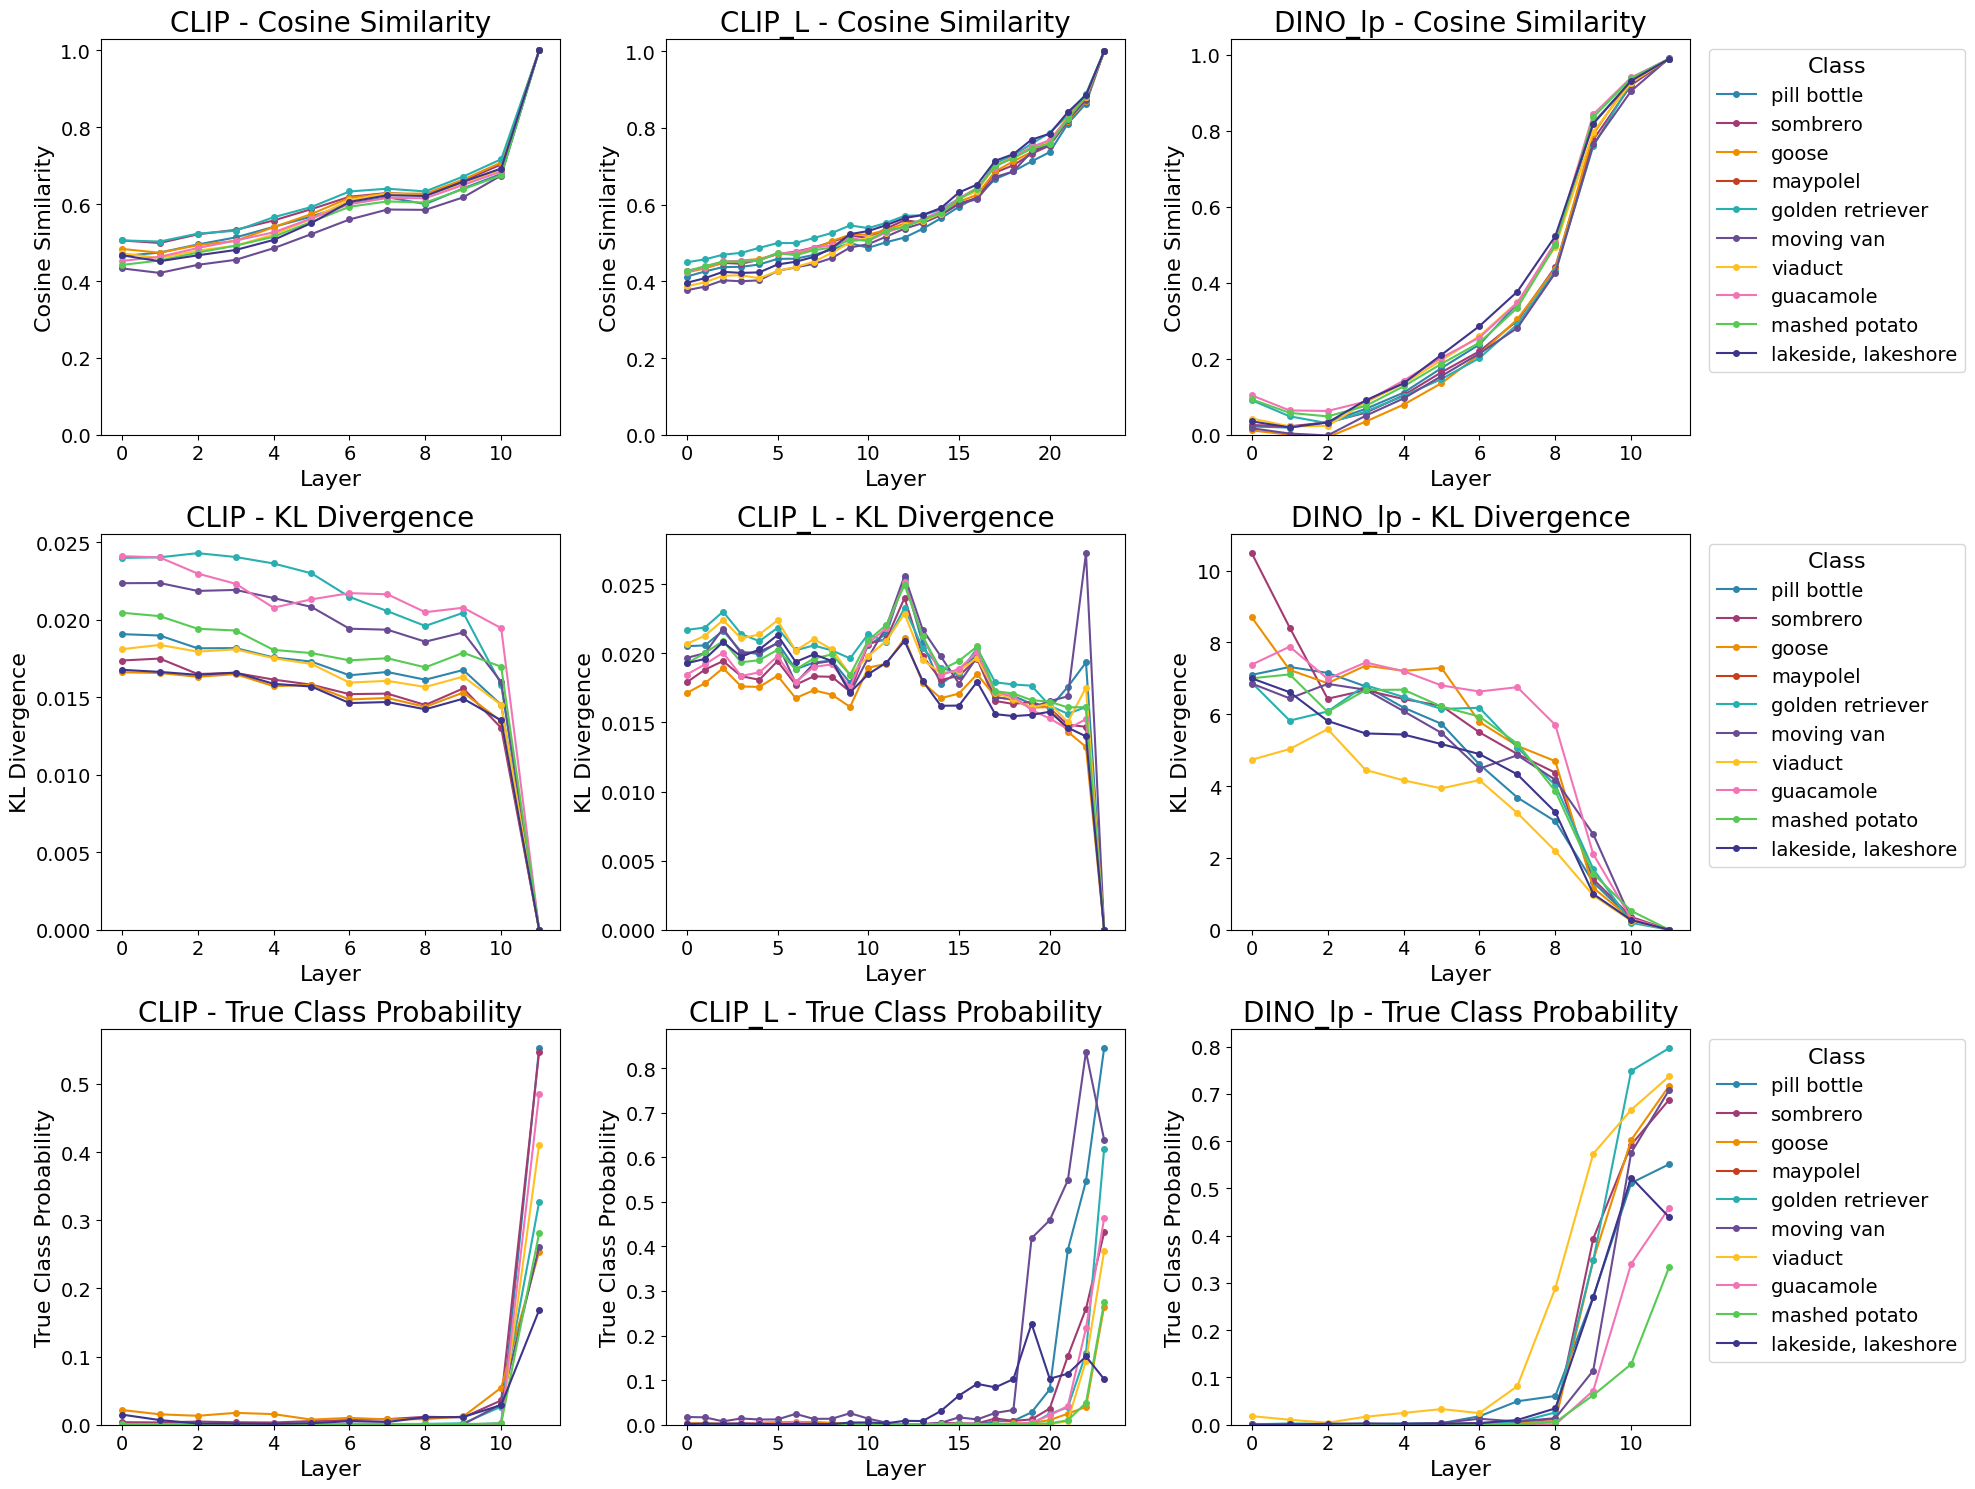

In [9]:
plot_metrics_for_classes(['pill bottle', 'sombrero', 'goose', 'maypolel', 'golden retriever', 'moving van', 'viaduct', 'guacamole','mashed potato', 'lakeside, lakeshore'], ['CLIP', 'CLIP_L', 'DINO_lp'], load_model_data)

### statistics

In [10]:
def generate_comparative_insights(model_results, comparison_df):
    """Generate research insights from the comparison"""
    
    print("=== COMPARATIVE RESEARCH INSIGHTS ===\n")
    
    models = list(model_results.keys())
    
    insights = [
        f"🔍 ARCHITECTURAL DIFFERENCES:",
        f"   • Layer Count Range: {comparison_df['Num_Layers'].min()}-{comparison_df['Num_Layers'].max()} layers",
        #f"   • Efficiency Spread: {comparison_df['Efficiency'].max() - comparison_df['Efficiency'].min():.4f}",
        f"   • Stability Variation: {comparison_df['Overall_Stability'].std():.4f}",
        "",
        
        f"📊 CONVERGENCE PATTERNS:"
    ]
    
    # Analyze convergence patterns
    for model_name, results in model_results.items():
        metrics = results['metrics']
        conv_layer = metrics['convergence_layer']
        total_layers = len(metrics['layer_nums'])
        if conv_layer:
            conv_ratio = conv_layer / total_layers
            insights.append(f"   • {model_name}: Converges at layer {conv_layer}/{total_layers} ({conv_ratio:.2%})")
        else:
            insights.append(f"   • {model_name}: No convergence to 80% similarity")
    # Find best models
    best_eff_model = comparison_df.loc[comparison_df['Efficiency'].idxmax()]
    best_stab_model = comparison_df.loc[comparison_df['Overall_Stability'].idxmax()]
    
    best_efficiency = f"{best_eff_model['Model']} ({best_eff_model['Efficiency']:.4f})"
    best_stability = f"{best_stab_model['Model']} ({best_stab_model['Overall_Stability']:.4f})"
    
    for insight in insights:
        print(insight)
    
    return insights

In [11]:

def run_complete_multi_model_analysis():
    """Run the complete multi-model analysis"""
    
    print("🚀 STARTING COMPREHENSIVE MULTI-MODEL LOGIT LENS ANALYSIS")
    print("="*70)
    
    model_results, comparison_df = compare_models_comprehensive()
    
    if model_results is None:
        print("❌ Analysis failed - no data loaded")
        return None
    
    
    print("\n✅ ANALYSIS COMPLETE!")


In [12]:
results = run_complete_multi_model_analysis()


🚀 STARTING COMPREHENSIVE MULTI-MODEL LOGIT LENS ANALYSIS
=== LOADING MODEL DATA ===
Critical layers saved to logit_lens_results/CLIP/critical_layers.csv

=== SUMMARY FOR MODEL: CLIP ===
• Layers analyzed: 12
• Final similarity: 1.0000
• Similarity range: 0.5243
• Overall stability: 70962.6150
• Convergence layer: 11
• Number of critical layers: 1
• Critical layers: 11, 9, 6
• Least critical: 1, 8, 3
• === Overall Most Critical Layers ===
   - Layer 11: Δ=0.3044
   - Layer 9: Δ=0.0396
   - Layer 6: Δ=0.0389
• === Overall Least Critical Layers ===
   - Layer 1: Δ=0.0075
   - Layer 8: Δ=0.0101
   - Layer 3: Δ=0.0143

=== PREDICTION CONSISTENCY SUMMARY ===
• Total images: 10000
• Images where final label appeared early: 762 (7.62%)
• Avg. first occurrence of final label: 10.79 (out of 12)
• Avg. fraction of layers matching final label: 0.01
• Avg. number of prediction plateaus per image: 2.19
• Avg. probability std across layers: 0.1185
Critical layers saved to logit_lens_results/CLIP_L/cr

### critical layers based on cosine similarity

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_critical_layers(path):

    df = pd.read_csv(path)
    #get model name from path
    model_name = path.split('/')[-2]

    # Only keep ranks 1, 2, 3
    df = df[df['rank'].isin([1, 2, 3])]

    # Prepare dictionaries for colors
    green_shades = {1: '#006319', 2: '#26b54a', 3: '#7af599'} 
    red_shades = {1: '#bd0d00', 2: '#f24b3f', 3: '#ff8a82'}    
    #new
    green_shades = {1: '#006319', 2: '#bd0d00', 3: '#26b54a'} 
    red_shades = {1: '#f24b3f', 2: '#7af599', 3: '#ff8a82'}  

    # Aggregate counts by layer, type, and rank
    counts = df.groupby(['type', 'rank', 'layer']).size().unstack(fill_value=0)

    # Prepare data for plotting: for each rank and type, we want counts per layer
    layers = sorted(df['layer'].unique())

    # Initialize a DataFrame for plotting
    plot_data = pd.DataFrame(index=layers)

    # Add columns for each type/rank combo
    for r in [1, 2, 3]:
        # Most Critical (green shades)
        most_crit_counts = df[(df['type'] == 'critical') & (df['rank'] == r)]['layer'].value_counts()
        plot_data[f'Most Critical Rank {r}'] = most_crit_counts.reindex(layers, fill_value=0)

        # Least Critical (red shades)
        least_crit_counts = df[(df['type'] == 'least_critical') & (df['rank'] == r)]['layer'].value_counts()
        plot_data[f'Least Critical Rank {r}'] = least_crit_counts.reindex(layers, fill_value=0)

    # Plot stacked bar chart
    colors = [
        green_shades[1], green_shades[2], green_shades[3],
        red_shades[1], red_shades[2], red_shades[3]
    ]

    plot_data.plot(
        kind='bar',
        stacked=True,
        color=colors,
        figsize=(6, 4)
    )

    plt.xlabel('Layer')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Layers as Most vs. Least Critical - {model_name}')
    plt.legend(
        title='Category and Rank',
        loc='upper center',
        bbox_to_anchor=(0.5, -0.30),  # y < 0 moves legend below the plot
        fontsize='small',
        frameon=True,
        ncol=3  # optional, arrange legend entries in a row
    )
    plt.tight_layout()
    plt.show()


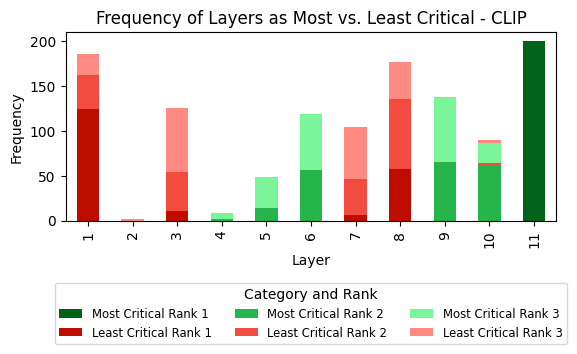

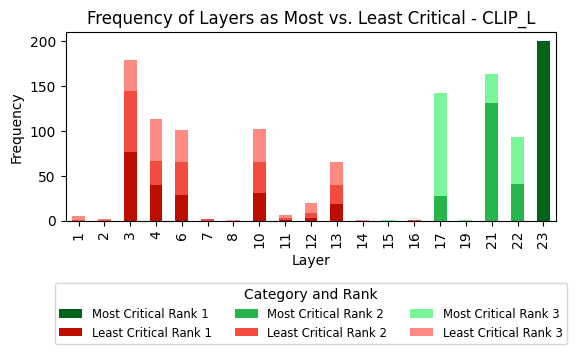

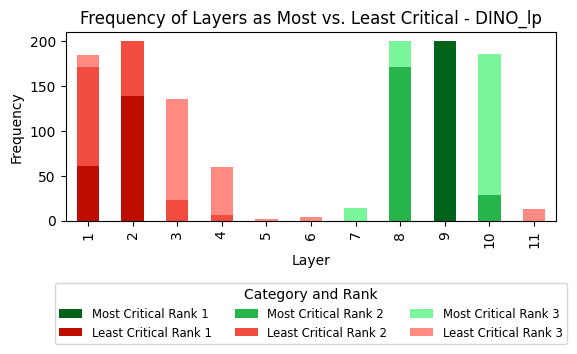

In [14]:
plot_critical_layers("logit_lens_results/CLIP/critical_layers.csv")
plot_critical_layers("logit_lens_results/CLIP_L/critical_layers.csv")
plot_critical_layers("logit_lens_results/DINO_lp/critical_layers.csv")

### accuracy analysis

In [15]:
import pandas as pd

def calculate_accuracy_of_model(path, top_n=10):
    df = pd.read_csv(path)
    model_name = path.split('/')[-2]

    # Calculate accuracy
    correct_predictions = df[df['True_Label'] == df['Last_Top1_Label']].shape[0]
    total_predictions = df.shape[0]
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    print(f"\n Accuracy of {model_name}: {accuracy:.4f} ({correct_predictions}/{total_predictions})")

    # Identify misclassified examples
    misclassified = df[df['True_Label'] != df['Last_Top1_Label']]

    # Count how often each true label was misclassified
    misclassified_counts = misclassified['True_Label'].value_counts().head(top_n)

    if not misclassified_counts.empty:
        print(f"\n Top {top_n} Most Misclassified Classes:")
        for label, count in misclassified_counts.items():
            print(f"  - {label}: {count} times")

            # Find top 5 labels it was misclassified as
            wrong_as = (
                misclassified[misclassified['True_Label'] == label]['Last_Top1_Label']
                .value_counts()
                .head(5)
            )

            for wrong_label, wcount in wrong_as.items():
                print(f"      → {wrong_label}: {wcount} times")
    else:
        print("\n No misclassifications found!")


In [16]:
calculate_accuracy_of_model("logit_lens_results/CLIP/last_layer_top_class_probs.csv")
calculate_accuracy_of_model("logit_lens_results/CLIP_L/last_layer_top_class_probs.csv")
calculate_accuracy_of_model("logit_lens_results/DINO_lp/last_layer_top_class_probs.csv")


 Accuracy of CLIP: 0.5594 (5594/10000)

 Top 10 Most Misclassified Classes:
  - cardigan: 50 times
      → vestment: 26 times
      → fur coat: 5 times
      → miniskirt, mini: 3 times
      → bee: 2 times
      → maypole: 2 times
  - beaker: 50 times
      → water jug: 12 times
      → hourglass: 7 times
      → pop bottle, soda bottle: 5 times
      → syringe: 5 times
      → pill bottle: 3 times
  - poncho: 50 times
      → vestment: 17 times
      → academic gown, academic robe, judge's robe: 10 times
      → fur coat: 4 times
      → punching bag, punch bag, punching ball, punchball: 2 times
      → backpack, back pack, knapsack, packsack, rucksack, haversack: 2 times
  - turnstile: 50 times
      → bannister, banister, balustrade, balusters, handrail: 7 times
      → pay-phone, pay-station: 6 times
      → butcher shop, meat market: 5 times
      → cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM: 4 times
 

### analiza konkretnych przypadków

#### displaying image


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import os
from collections import defaultdict

In [10]:
def set_all_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_all_seeds(42)

In [11]:

# Config
RANDOM_SEED = 42
SUBSET_FRACTION = 0.1  # 0.05 for 5%, 0.1 for 10%
BATCH_SIZE = 64

# Transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

# Load full dataset
train_dir = os.path.join("./tiny-imagenet-200", "train")
full_dataset = datasets.ImageFolder(train_dir, transform=transform)

# Group indices by class
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(full_dataset.samples):
    class_indices[label].append(idx)

# Stratified sampling
rng = random.Random(RANDOM_SEED)
subset_indices = []
for label, indices in class_indices.items():
    rng.shuffle(indices)  # shuffle within each class
    n_select = int(SUBSET_FRACTION * len(indices))
    n_select = max(n_select, 1)  # ensure at least 1 per class
    subset_indices.extend(indices[:n_select])

# Sort for consistent image loading order
subset_indices = sorted(subset_indices)

# Create subset dataset
subset_dataset = Subset(full_dataset, subset_indices)
train_loader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [28]:

def display_image_by_id(dataset, image_label, unnormalize=True, mean=(0.4815, 0.4578, 0.4082), std=(0.2686, 0.2613, 0.2758)):
    """
    Displays the image corresponding to a label like "Image_123" from the dataset.
    
    Args:
        dataset: PyTorch dataset.
        image_label (str): String like "Image_123".
        unnormalize (bool): Whether to reverse normalization (for CLIP or ImageNet preprocessing).
        mean (tuple): Mean used in normalization.
        std (tuple): Std used in normalization.
    """
    if not image_label.startswith("Image_"):
        raise ValueError("image_label must be in the format 'Image_123'.")

    try:
        index = int(image_label.split("_")[1]) - 1
        image, label = dataset[index]  # (C, H, W) tensor

        # Unnormalize if needed
        if unnormalize and isinstance(image, torch.Tensor):
            image = image.clone()
            for c in range(3):
                image[c] = image[c] * std[c] + mean[c]
            image = torch.clamp(image, 0, 1)

        # Convert to numpy HWC for matplotlib
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()

        # Display
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(f"{image_label} | Class ID: {label}")
        plt.axis('off')
        plt.show()
       

    except IndexError:
        print(f"Index {index} is out of bounds for dataset of length {len(dataset)}.")
    


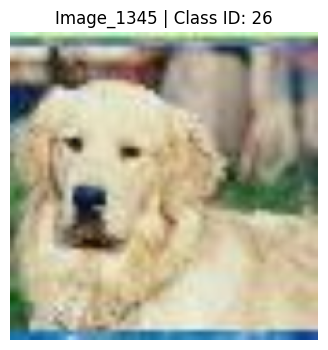

In [29]:
display_image_by_id(subset_dataset, "Image_1345", unnormalize=True)

#### plotting

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_probabilities_for_image(image_id, folder_path):
    # Extract model name from the folder path
    model_name = os.path.basename(folder_path.strip("/\\"))

    # File paths
    files = {
        'true': 'true_class_probs.csv',
        'first': 'first_top_class_probs.csv',
        'last': 'last_layer_top_class_probs.csv',
        'second':'second_last_layer_top_class_probs.csv',
        'third':'third_last_layer_top_class_probs.csv'
    }

    # Load DataFrames
    dfs = {key: pd.read_csv(os.path.join(folder_path, filename)) for key, filename in files.items()}

    # Get the specific rows for the selected image
    true_row = dfs['true'].query("Image == @image_id").iloc[0]
    first_row = dfs['first'].query("Image == @image_id").iloc[0]
    last_row = dfs['last'].query("Image == @image_id").iloc[0]
    second_row = dfs['second'].query("Image == @image_id").iloc[0]
    third_row = dfs['third'].query("Image == @image_id").iloc[0]

    # Get layer columns
    layer_cols = [col for col in dfs['true'].columns if col.startswith("layer_")]
    layers = [int(col.split('_')[1]) for col in layer_cols]

    # Build plot data
    plot_data = {
        f"True: {true_row['True_Label']}": true_row[layer_cols].astype(float).values
    }
    if first_row['First_Top1_Label'] != true_row['True_Label']:
        plot_data[f"First: {first_row['First_Top1_Label']}"] = first_row[layer_cols].astype(float).values

    if last_row['Last_Top1_Label'] != true_row['True_Label']:
        plot_data[f"Last: {last_row['Last_Top1_Label']}"] = last_row[layer_cols].astype(float).values

    if second_row['Second_Last_Top1_Label'] != true_row['True_Label']:
        plot_data[f"Second Last: {second_row['Second_Last_Top1_Label']}"] = second_row[layer_cols].astype(float).values

    if third_row['Third_Last_Top1_Label'] != true_row['True_Label']:
        plot_data[f"Third Last: {third_row['Third_Last_Top1_Label']}"] = third_row[layer_cols].astype(float).values

    # Plotting
    plt.figure(figsize=(10, 5))
    for label, values in plot_data.items():
        plt.plot(layers, values, label=label, marker='o')

    plt.title(f'{model_name} - Layer-wise Class Probabilities for {image_id}', fontsize=18)
    plt.xlabel('Layer', fontsize=14)
    plt.ylabel('Probability', fontsize=14)
    plt.xticks(layers, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    display_image_by_id(subset_dataset, image_id, unnormalize=True)

    # Print final predictions and their probabilities from the last layer
    last_layer = f"layer_{max(layers)}"
    print("\nFinal Predictions at Last Layer:")
    print(f"Predicted: {last_row['Last_Top1_Label']} | Probability: {last_row[last_layer]:.4f}")
    print(f"Second most likely: {second_row['Second_Last_Top1_Label']} | Probability: {second_row[last_layer]:.4f}")
    print(f"Third most likely: {third_row['Third_Last_Top1_Label']} | Probability: {third_row[last_layer]:.4f}")


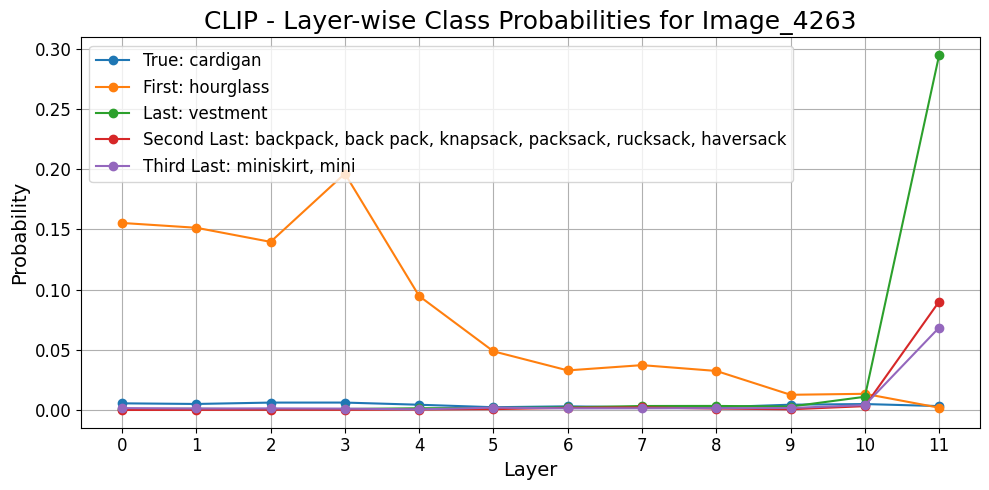

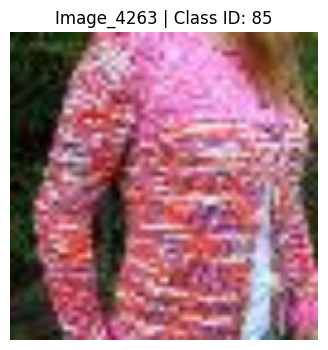


Final Predictions at Last Layer:
Predicted: vestment | Probability: 0.2946
Second most likely: backpack, back pack, knapsack, packsack, rucksack, haversack | Probability: 0.0901
Third most likely: miniskirt, mini | Probability: 0.0685


In [60]:
plot_probabilities_for_image('Image_4263', 'logit_lens_results/CLIP')

### unique classes per layer

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_models_unique_labels(model_csv_dict):
    """
    model_csv_dict: dict where keys are model names and values are CSV file paths
    """
    num_models = len(model_csv_dict)
    fig, axes = plt.subplots(1, num_models, figsize=(7 * num_models, 6), sharey=True)

    if num_models == 1:
        axes = [axes]  # Ensure iterable

    for ax, (model_name, csv_path) in zip(axes, model_csv_dict.items()):
        df = pd.read_csv(csv_path)

        # Get label columns
        label_cols = [col for col in df.columns if col.endswith('_label') and col.startswith('layer_')]
        unique_counts = {col: df[col].nunique() for col in label_cols}

        # Sort by layer number
        sorted_counts = sorted(
            [(int(col.split('_')[1]), count) for col, count in unique_counts.items()],
            key=lambda x: x[0]
        )
        layers, counts = zip(*sorted_counts)

        # Plot
        ax.bar(layers, counts, color='skyblue')
        ax.set_title(f"{model_name}", fontsize=20)
        ax.set_xlabel("Layer", fontsize=18)
        ax.set_xticks(layers)
        ax.tick_params(axis='x', labelrotation=60, labelsize=16)
        ax.tick_params(axis='y', labelsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Shared Y-axis label
    axes[0].set_ylabel("Number of Unique Predicted Labels", fontsize=18)

    plt.suptitle("Unique Predicted Labels per Layer (Overall)", fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()


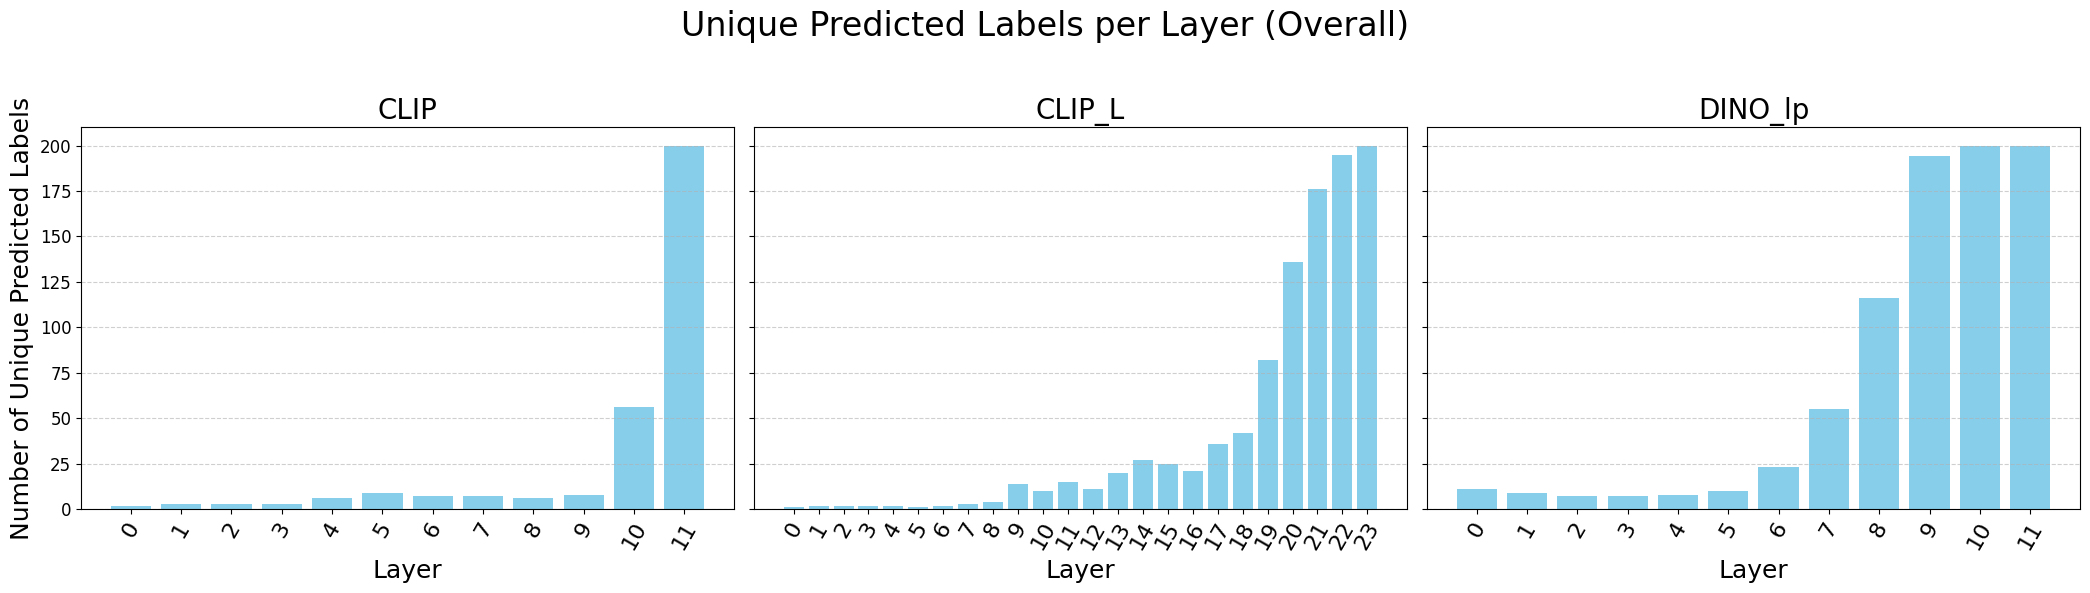

In [20]:
compare_models_unique_labels({
    'CLIP': 'logit_lens_results/CLIP/predictions.csv',
    'CLIP_L': 'logit_lens_results/CLIP_L/predictions.csv',
    'DINO_lp': 'logit_lens_results/DINO_lp/predictions.csv'
})

### per class analysis

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_unique_labels_and_avg_prob_per_layer(label_csv_path, prob_csv_path=None, second_prob_csv_path=None, true_label=None):
    # Load label CSV
    df_labels = pd.read_csv(label_csv_path)
    model_name = label_csv_path.split('/')[-2]

    if true_label is not None:
        df_labels = df_labels[df_labels['True_Label'] == true_label]

    label_cols = [col for col in df_labels.columns if col.endswith('_label') and col.startswith('layer_')]

    # Get new unique labels per layer
    seen_labels = set()
    unique_new_labels_per_layer = []
    for col in sorted(label_cols, key=lambda x: int(x.split('_')[1])):
        labels_in_layer = set(df_labels[col].unique())
        new_labels = labels_in_layer - seen_labels
        seen_labels.update(labels_in_layer)
        unique_new_labels_per_layer.append(list(new_labels)[:2])

    # Count unique labels
    unique_counts = {col: df_labels[col].nunique() for col in label_cols}
    sorted_counts = []
    has_true_label = []

    for col in label_cols:
        layer_num = int(col.split('_')[1])
        sorted_counts.append((layer_num, unique_counts[col]))
        if true_label:
            labels_in_layer = df_labels[col].unique()
            has_true_label.append(true_label in labels_in_layer)
        else:
            has_true_label.append(False)

    sorted_data = sorted(zip(sorted_counts, has_true_label), key=lambda x: x[0][0])
    layers, counts = zip(*[item[0] for item in sorted_data])
    borders = [item[1] for item in sorted_data]

    # Load primary probability CSV
    avg_probs = None
    if prob_csv_path and true_label:
        df_probs = pd.read_csv(prob_csv_path)
        df_probs = df_probs[df_probs['True_Label'] == true_label]
        prob_cols = [col for col in df_probs.columns if col.startswith('layer_')]
        avg_probs = [df_probs[col].mean() for col in prob_cols]
        avg_probs = [avg for _, avg in sorted(zip([int(c.split('_')[1]) for c in prob_cols], avg_probs))]

    # Load second probability CSV
    second_avg_probs = None
    if second_prob_csv_path and true_label:
        df_probs2 = pd.read_csv(second_prob_csv_path)
        df_probs2 = df_probs2[df_probs2['True_Label'] == true_label]
        second_label = df_probs2['Second_Last_Top1_Label'].iloc[0]
        second_prob_cols = [col for col in df_probs2.columns if col.startswith('layer_')]
        second_avg_probs = [df_probs2[col].mean() for col in second_prob_cols]
        second_avg_probs = [avg for _, avg in sorted(zip([int(c.split('_')[1]) for c in second_prob_cols], second_avg_probs))]

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bars = ax1.bar(layers, counts, color='skyblue', edgecolor='none')

    for bar, highlight in zip(bars, borders):
        if highlight:
            bar.set_edgecolor('darkblue')
            bar.set_linewidth(2)

    for i, (bar, new_labels) in enumerate(zip(bars, unique_new_labels_per_layer)):
        if i == 0:
            first_layer_col = sorted(label_cols, key=lambda x: int(x.split('_')[1]))[0]
            all_labels = set(df_labels[first_layer_col].unique())
            label_text = ', '.join([str(l).split(',')[0] for l in all_labels])
        else:
            if new_labels:
                label_text = str(new_labels[0]).split(',')[0]
            else:
                label_text = ''
        if label_text:
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.3,
                label_text,
                ha='center',
                va='bottom',
                fontsize=10,
                color='black',
                rotation=90
            )

    ax1.set_xlabel("Layer", fontsize=14)
    ax1.set_ylabel("Number of Unique Labels", fontsize=14, color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_xticks(layers)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Secondary axis: original probability line
    if avg_probs is not None or second_avg_probs is not None:
        ax2 = ax1.twinx()

        if avg_probs:
            ax2.plot(layers, avg_probs, color='darkorange', marker='o', linestyle='-', linewidth=2,
                     label=f"Average prob. of '{true_label}' - ground truth")

        if second_avg_probs:
            ax2.plot(layers, second_avg_probs, color='green', marker='s', linestyle='--', linewidth=2,
                     label=f"Average prob. of '{second_label}' - second most probable on last layer")

        ax2.set_ylabel("Average Probability", fontsize=14)
        ax2.tick_params(axis='y', labelcolor='darkgreen')
        ax2.set_ylim(0, 1)
        ax2.legend(loc='upper left')

    title = f"Unique Predicted Labels per Layer" + (f" for '{true_label}'" if true_label else " (Overall)")
    title += f" - {model_name}"
    plt.title(title, fontsize=16)
    fig.tight_layout()
    plt.show()


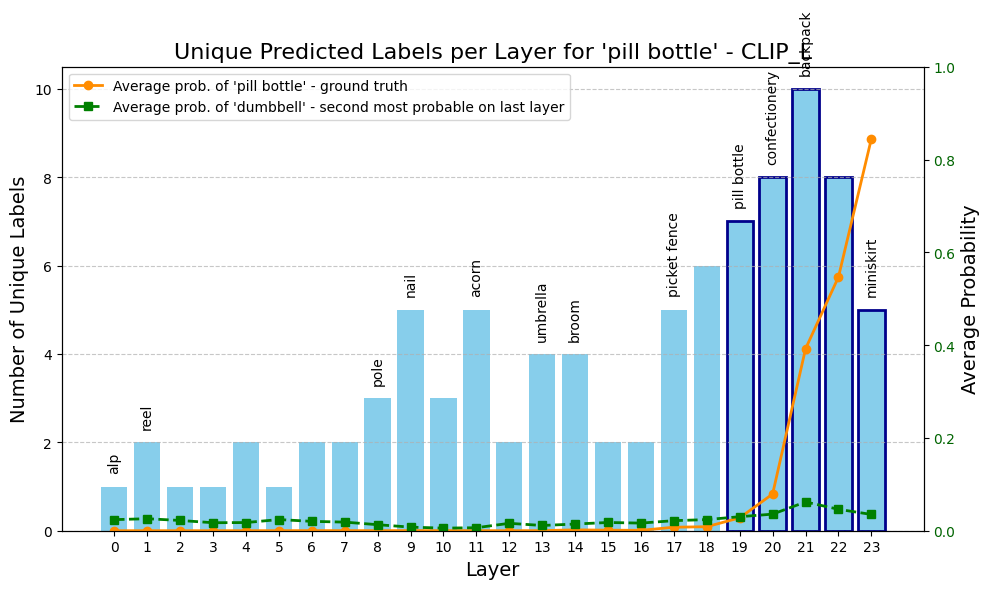

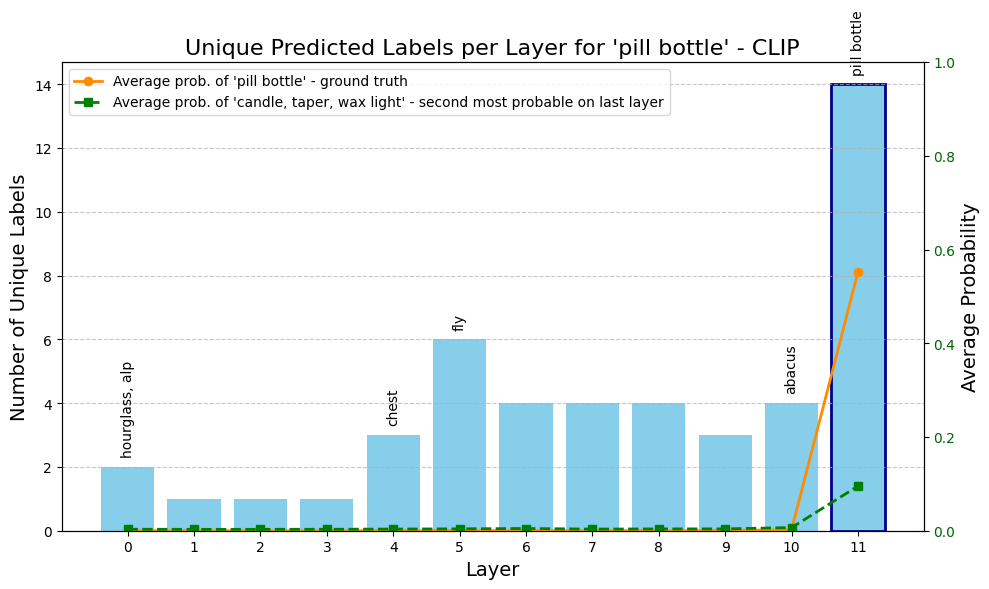

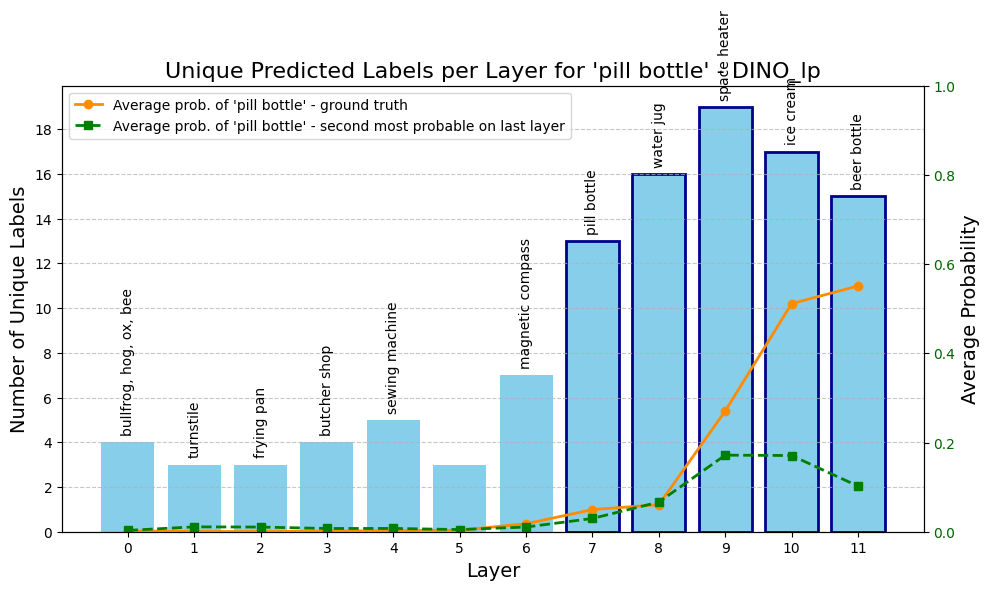

In [22]:
plot_unique_labels_and_avg_prob_per_layer(
    label_csv_path='logit_lens_results/CLIP_L/predictions.csv',
    prob_csv_path='logit_lens_results/CLIP_L/true_class_probs.csv',
    true_label='pill bottle',  # or any other label you want to analyze,
    second_prob_csv_path='logit_lens_results/CLIP_L/second_last_layer_top_class_probs.csv'  # optional
)
plot_unique_labels_and_avg_prob_per_layer(
    label_csv_path='logit_lens_results/CLIP/predictions.csv',
    prob_csv_path='logit_lens_results/CLIP/true_class_probs.csv',
    true_label='pill bottle',  # or any other label you want to analyze,
    second_prob_csv_path='logit_lens_results/CLIP/second_last_layer_top_class_probs.csv'  # optional
)
plot_unique_labels_and_avg_prob_per_layer(
    label_csv_path='logit_lens_results/DINO_lp/predictions.csv',
    prob_csv_path='logit_lens_results/DINO_lp/true_class_probs.csv',
    true_label='pill bottle',  # or any other label you want to analyze
    second_prob_csv_path='logit_lens_results/DINO_lp/second_last_layer_top_class_probs.csv'  # optional
)

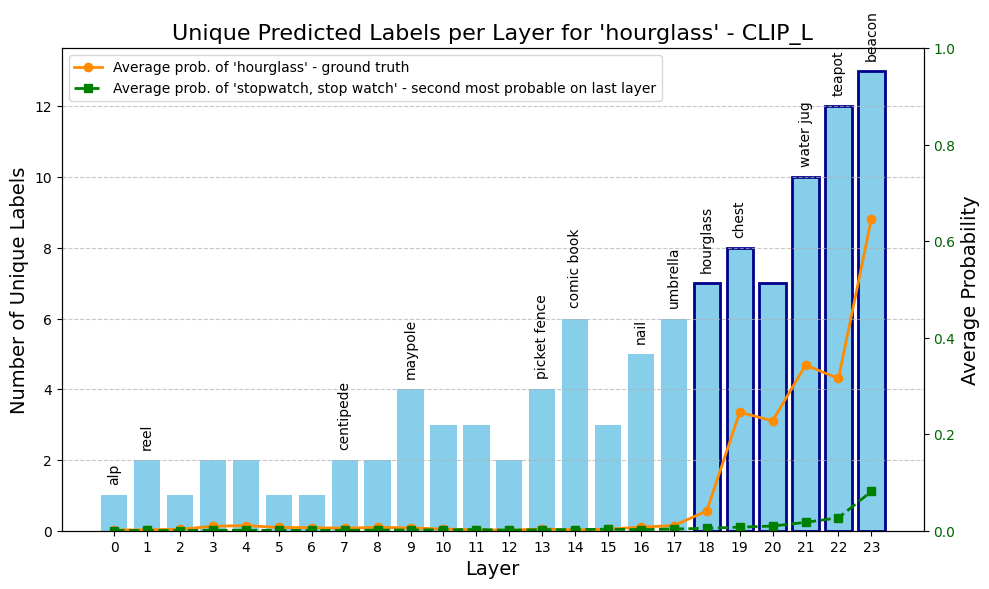

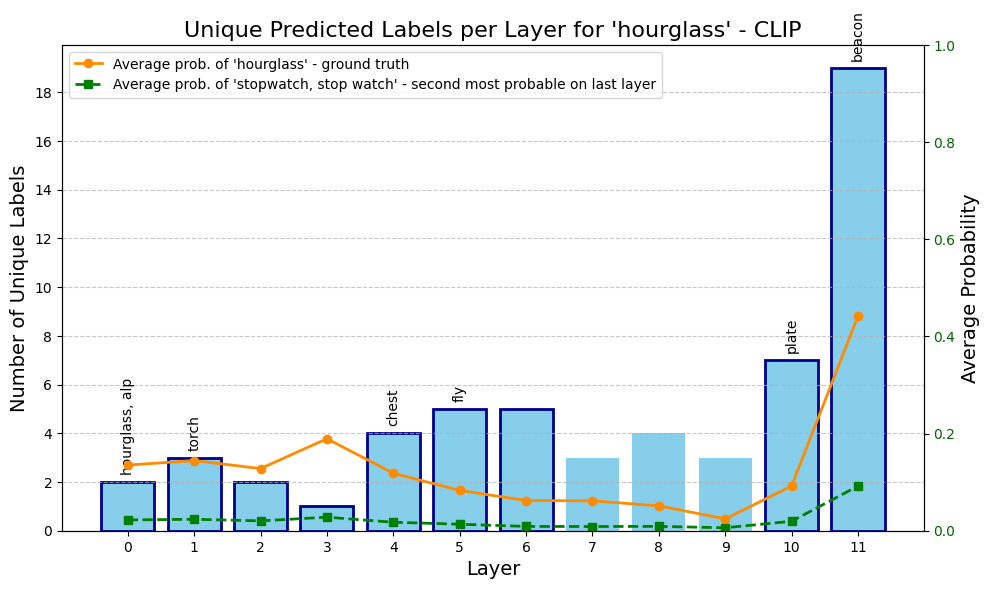

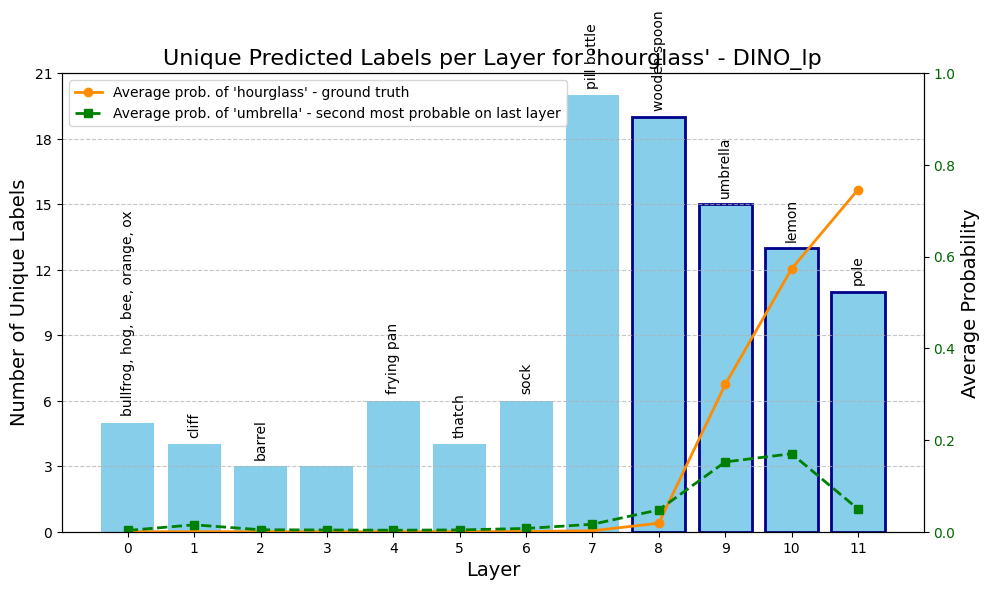

In [23]:
plot_unique_labels_and_avg_prob_per_layer(
    label_csv_path='logit_lens_results/CLIP_L/predictions.csv',
    prob_csv_path='logit_lens_results/CLIP_L/true_class_probs.csv',
    true_label="hourglass",  # or any other label you want to analyze
    second_prob_csv_path='logit_lens_results/CLIP_L/second_last_layer_top_class_probs.csv'  # optional
)
plot_unique_labels_and_avg_prob_per_layer(
    label_csv_path='logit_lens_results/CLIP/predictions.csv',
    prob_csv_path='logit_lens_results/CLIP/true_class_probs.csv',
    true_label="hourglass",  # or any other label you want to analyze
    second_prob_csv_path='logit_lens_results/CLIP/second_last_layer_top_class_probs.csv'  # optional
)
plot_unique_labels_and_avg_prob_per_layer(
    label_csv_path='logit_lens_results/DINO_lp/predictions.csv',
    prob_csv_path='logit_lens_results/DINO_lp/true_class_probs.csv',
    true_label="hourglass",  # or any other label you want to analyze
    second_prob_csv_path='logit_lens_results/DINO_lp/second_last_layer_top_class_probs.csv'  # optional
)